In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from skimage import io
from skimage.transform import resize


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K


In [ ]:
sns.set(font_scale=1.6)

In [1]:
#### Data visualization ####

# Code to convert the xls file to csv
data_xls = pd.read_excel('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx', 
                         dtype=str, index_col=None)
data_xls.to_csv('odir5k_data.csv', encoding='utf-8', index=False)

In [ ]:
# Read the ODIR5K train dataset
train_df = pd.read_csv('odir5k_data.csv')

# Listing the images
images_paths = '../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images'
images_list = os.listdir(images_paths) 
print(f'Total number of images in train set {len(images_list)}')
print(f'Total number of rows in train dataset  {len(train_df)}')

Total number of images in train set 7000
Total number of rows in train dataset  3500


In [ ]:
train_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
# Names of columns in the new dataframe
col_names = ['Image', 'Diagnosis', 'Age', 'Sex']

# DataFrame for left-eye images
eyes_L = train_df[['Left-Fundus', 'Left-Diagnostic Keywords', 'Patient Age', 'Patient Sex']]
eyes_L.columns = col_names

# DataFrame for right-eye images
eyes_R = train_df[['Right-Fundus', 'Right-Diagnostic Keywords', 'Patient Age', 'Patient Sex']]
eyes_R.columns = col_names

# DataFrame for left-eye and right-eye images combined
eyes_df = pd.concat([eyes_L, eyes_R], axis=0)

eyes_df.head()


,Image,Diagnosis,Age,Sex
0,0_left.jpg,cataract,69,Female
1,1_left.jpg,normal fundus,57,Male
2,2_left.jpg,laser spot，moderate non proliferative retinopathy,42,Male
3,3_left.jpg,normal fundus,66,Male
4,4_left.jpg,macular epiretinal membrane,53,Male


In [ ]:
def has_disease(disease, text):
    if disease in text:
        return 1
    else:
        return 0

In [ ]:
#Using Cataract data
keywords = ['normal', 'cataract']
class_cols = ['Normal','Cataract']

for keyword, class_col in zip(keywords, class_cols):
    eyes_df[class_col] = eyes_df['Diagnosis'].apply(lambda x: has_disease(keyword, x))  


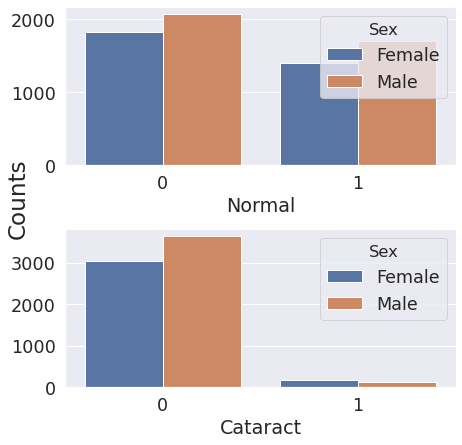

In [ ]:
fig, axis = plt.subplots(2, 1, figsize=(7,7))

for ax, class_col in zip(axis.reshape(-1), class_cols):
    sns.countplot(ax=ax, x=class_col, hue='Sex', data=eyes_df)
    ax.set_ylabel('')
plt.subplots_adjust(hspace=0.4, wspace=0.25)
fig.text(0.01, 0.5, 'Counts', va='center', rotation='vertical', fontsize='large')
plt.show()

In [ ]:
#### Creating the dataset ####
# Normal sample
normal = eyes_df[eyes_df.Normal == 1].copy()
normal.loc[:, 'Label'] = 0

# Cataract sample
cataract = eyes_df[eyes_df.Cataract == 1].copy()
cataract.loc[:, 'Label'] = 1

dataset = pd.concat([normal, cataract])

dataset = dataset.drop(columns=class_cols)


In [ ]:
dataset.head()

,Image,Diagnosis,Age,Sex,Label
1,1_left.jpg,normal fundus,57,Male,0
3,3_left.jpg,normal fundus,66,Male,0
8,8_left.jpg,normal fundus,59,Male,0
9,9_left.jpg,normal fundus,54,Male,0
14,14_left.jpg,normal fundus,55,Male,0


In [ ]:
# Training and testing folders
#os.mkdir('my_training_images')
#os.mkdir('my_testing_images')

In [ ]:
#import shutil
#shutil.rmtree('my_training_images/Normal')
#shutil.rmtree('my_testing_images/Normal')

In [ ]:
# Creating folder classes:
for label, class_col in enumerate(class_cols):
    y = dataset.loc[dataset['Label'] == label, 'Label']
    x = dataset.loc[dataset['Label'] == label, 'Image']
    img_train, img_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=10)

    os.mkdir('my_training_images/' + class_col)
    os.mkdir('my_testing_images/' + class_col)
    for img in img_train:
        shutil.copy('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'+img, './my_training_images/'+class_col+'/'+img)
    for img in img_test:
        shutil.copy('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'+img, './my_testing_images/'+class_col+'/'+img)
        

In [ ]:
print(len(normal), len(cataract))

3104 313


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Dimensions of our images
img_width, img_height = 250, 250

In [ ]:
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
        'my_training_images/', 
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary') 
test_generator = test_datagen.flow_from_directory(
        'my_testing_images/',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 2733 images belonging to 2 classes.
Found 684 images belonging to 2 classes.


In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
nb_train_samples = 2000
nb_validation_samples = 650

epochs = 15

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 248, 248, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
activation_6 (Activation)    (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 64)       

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('cataract_first_try.h5')


Epoch 1/15
62/62 [==============================] - 124s 2s/step - loss: 0.3562 - accuracy: 0.8987 - val_loss: 0.3479 - val_accuracy: 0.9016
Epoch 2/15
62/62 [==============================] - 124s 2s/step - loss: 0.3219 - accuracy: 0.9074 - val_loss: 0.2946 - val_accuracy: 0.9016
Epoch 3/15
62/62 [==============================] - 125s 2s/step - loss: 0.2785 - accuracy: 0.9135 - val_loss: 0.4713 - val_accuracy: 0.9016
Epoch 4/15
62/62 [==============================] - 122s 2s/step - loss: 0.2730 - accuracy: 0.9115 - val_loss: 0.3125 - val_accuracy: 0.9031
Epoch 5/15
62/62 [==============================] - 123s 2s/step - loss: 0.2717 - accuracy: 0.9125 - val_loss: 0.2645 - val_accuracy: 0.9047
Epoch 6/15
62/62 [==============================] - 123s 2s/step - loss: 0.2416 - accuracy: 0.9189 - val_loss: 0.4105 - val_accuracy: 0.9031
Epoch 7/15
62/62 [==============================] - 124s 2s/step - loss: 0.2349 - accuracy: 0.9158 - val_loss: 0.2875 - val_accuracy: 0.9078
Epoch 8/15
62

In [ ]:
y_pred = [1 if i > 0.5 else 0 for i in model.predict(test_generator)]
y_test = test_generator.classes
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = ['Cataract', 'Normal'],
                  columns = ['Cataract', 'Normal'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [ ]:
## Balancing the dataset ##
# Training and testing folders
os.mkdir('my_training_balanced')
os.mkdir('my_testing_balanced')

In [ ]:
size = len(cataract)
print(size)

313


In [ ]:
# Creating folder classes:
for label, class_col in enumerate(class_cols):
    y = dataset.loc[dataset['Label'] == label, 'Label'].sample(n=size, random_state=1)
    x = dataset.loc[dataset['Label'] == label, 'Image'].sample(n=size, random_state=1)
    img_train, img_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=10)

    os.mkdir('my_training_balanced/' + class_col)
    os.mkdir('my_testing_balanced/' + class_col)
    for img in img_train:
        shutil.copy('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'+img, './my_training_balanced/'+class_col+'/'+img)
    for img in img_test:
        shutil.copy('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'+img, './my_testing_balanced/'+class_col+'/'+img)
        

In [ ]:
train_generator = train_datagen.flow_from_directory(
        'my_training_balanced/', 
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary') 
test_generator = test_datagen.flow_from_directory(
        'my_testing_balanced/',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 500 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [ ]:
nb_train_samples = 2000
nb_validation_samples = 120

epochs = 15

In [ ]:
model_balanced = Sequential()
model_balanced.add(Conv2D(32, (3, 3), input_shape=input_shape))
model_balanced.add(Activation('relu'))
model_balanced.add(MaxPooling2D(pool_size=(2, 2)))

model_balanced.add(Conv2D(32, (3, 3)))
model_balanced.add(Activation('relu'))
model_balanced.add(MaxPooling2D(pool_size=(2, 2)))

model_balanced.add(Conv2D(64, (3, 3)))
model_balanced.add(Activation('relu'))
model_balanced.add(MaxPooling2D(pool_size=(2, 2)))

model_balanced.add(Flatten())
model_balanced.add(Dense(64))
model_balanced.add(Activation('relu'))
model_balanced.add(Dropout(0.5))
model_balanced.add(Dense(1))
model_balanced.add(Activation('softmax'))

model_balanced.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
history_balanced = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_validation_samples // batch_size)

model_balanced.save_weights('cataract_balanced_try.h5')

Epoch 1/15
62/62 [==============================] - 99s 2s/step - loss: 0.0975 - accuracy: 0.9684 - val_loss: 3.1885 - val_accuracy: 0.4688
Epoch 2/15
62/62 [==============================] - 98s 2s/step - loss: 0.0707 - accuracy: 0.9768 - val_loss: 1.2322 - val_accuracy: 0.8438
Epoch 3/15
62/62 [==============================] - 97s 2s/step - loss: 0.0777 - accuracy: 0.9730 - val_loss: 1.4074 - val_accuracy: 0.8438
Epoch 4/15
62/62 [==============================] - 99s 2s/step - loss: 0.0828 - accuracy: 0.9723 - val_loss: 1.4209 - val_accuracy: 0.8021
Epoch 5/15
62/62 [==============================] - 102s 2s/step - loss: 0.1146 - accuracy: 0.9746 - val_loss: 3.0164 - val_accuracy: 0.7708
Epoch 6/15
62/62 [==============================] - 98s 2s/step - loss: 0.0705 - accuracy: 0.9746 - val_loss: 1.2735 - val_accuracy: 0.7917
Epoch 7/15
62/62 [==============================] - 98s 2s/step - loss: 0.0814 - accuracy: 0.9730 - val_loss: 1.3536 - val_accuracy: 0.8229
Epoch 8/15
62/62 [=

In [ ]:
y_pred = [1 if i > 0.5 else 0 for i in model_balanced.predict(test_generator)]
y_test = test_generator.classes
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.50      1.00      0.67        63

    accuracy                           0.50       126
   macro avg       0.25      0.50      0.33       126
weighted avg       0.25      0.50      0.33       126



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = ['Normal', 'Cataract'],
                  columns = ['Cataract', 'Normal'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [2]:
#Using VGG19 model
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)

In [ ]:
for layer in vgg19.layers:
    layer.trainable = False
    

In [3]:
model_vgg19 = Sequential()
model_vgg19.add(vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(1, activation="sigmoid"))


In [ ]:
model_vgg19.summary()


In [ ]:
model_vgg19.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [ ]:
epochs = 15

In [ ]:
history_vgg19 = model_vgg19.fit(train_generator, 
                    steps_per_epoch=nb_train_samples // batch_size, 
                    epochs=epochs, 
                    validation_data=test_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    verbose=1)
model_vgg19.save_weights('cataract_balanced_vgg19_try.h5')


In [ ]:
y_pred = [1 if i > 0.5 else 0 for i in model_vgg19.predict(test_generator)]
y_test = test_generator.classes
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.50      1.00      0.67        63

    accuracy                           0.50       126
   macro avg       0.25      0.50      0.33       126
weighted avg       0.25      0.50      0.33       126



In [ ]:
sns.set(font_scale=1.6)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = ['Normal', 'Cataract'],
                  columns = ['Normal', 'Cataract'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [ ]:
#Using Diabetic data
eyes_df['Diabetic'] = eyes_df['Diagnosis'].apply(lambda x: has_disease('proliferative retinopathy', x))  
 
diabetic = eyes_df[eyes_df.Diabetic == 1].copy()
diabetic.loc[:, 'Label'] = 1
 
dataset2 = pd.concat([normal, diabetic])


dataset2 = dataset2.drop(columns=class_cols)

In [ ]:
os.mkdir('my_training_diabetic')
os.mkdir('my_testing_diabetic')

In [ ]:
class_cols = ['Normal','Diabetic']
size = len(diabetic)
for label, class_col in enumerate(class_cols):
    y = dataset2.loc[dataset2['Label'] == label, 'Label'].sample(n=size, random_state=1)
    x = dataset2.loc[dataset2['Label'] == label, 'Image'].sample(n=size, random_state=1)
    img_train, img_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=10)

 

    #os.mkdir('my_training_diabetic/' + class_col)
    #os.mkdir('my_testing_diabetic/' + class_col)
    for img in img_train:
        shutil.copy('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'+img, './my_training_diabetic/'+class_col+'/'+img)
    for img in img_test:
        shutil.copy('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'+img, './my_testing_diabetic/'+class_col+'/'+img)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        'my_training_diabetic/',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        'my_testing_diabetic/',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 2728 images belonging to 2 classes.
Found 684 images belonging to 2 classes.


In [ ]:
model_balanced_diabetic = Sequential()
model_balanced_diabetic.add(Conv2D(32, (3, 3), input_shape=input_shape))
model_balanced_diabetic.add(Activation('relu'))
model_balanced_diabetic.add(MaxPooling2D(pool_size=(2, 2)))

model_balanced_diabetic.add(Conv2D(32, (3, 3)))
model_balanced_diabetic.add(Activation('relu'))
model_balanced_diabetic.add(MaxPooling2D(pool_size=(2, 2)))

model_balanced_diabetic.add(Conv2D(64, (3, 3)))
model_balanced_diabetic.add(Activation('relu'))
model_balanced_diabetic.add(MaxPooling2D(pool_size=(2, 2)))

model_balanced_diabetic.add(Flatten())
model_balanced_diabetic.add(Dense(64))
model_balanced_diabetic.add(Activation('relu'))
model_balanced_diabetic.add(Dropout(0.5))
model_balanced_diabetic.add(Dense(1))
model_balanced_diabetic.add(Activation('sigmoid'))

model_balanced_diabetic.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history_balanced_diabetic = model_balanced_diabetic.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_validation_samples // batch_size)

model_balanced.save_weights('diabetic_balanced_try.h5')

Epoch 1/15
62/62 [==============================] - 100s 2s/step - loss: 0.6932 - accuracy: 0.5628 - val_loss: 0.6689 - val_accuracy: 0.6458
Epoch 2/15
62/62 [==============================] - 98s 2s/step - loss: 0.6798 - accuracy: 0.5730 - val_loss: 0.7072 - val_accuracy: 0.3229
Epoch 3/15
62/62 [==============================] - 98s 2s/step - loss: 0.6722 - accuracy: 0.5974 - val_loss: 0.6084 - val_accuracy: 0.6979
Epoch 4/15
62/62 [==============================] - 99s 2s/step - loss: 0.6728 - accuracy: 0.5878 - val_loss: 0.6144 - val_accuracy: 0.6979
Epoch 5/15
62/62 [==============================] - 98s 2s/step - loss: 0.6666 - accuracy: 0.5724 - val_loss: 0.6746 - val_accuracy: 0.6562
Epoch 6/15
62/62 [==============================] - 98s 2s/step - loss: 0.6660 - accuracy: 0.5939 - val_loss: 0.6375 - val_accuracy: 0.6771
Epoch 7/15
62/62 [==============================] - 100s 2s/step - loss: 0.6692 - accuracy: 0.5892 - val_loss: 0.6727 - val_accuracy: 0.5833
Epoch 8/15
62/62 [